# Notebook 03: Growth Dynamics and Asset Fluctuations

This notebook explores:
- Impact of growth parameters on long-term wealth accumulation
- Asset volatility under different insurance structures
- Operating margin dynamics and their interaction with claims
- Return on Assets (ROA) distributions
- Sensitivity analysis of key growth parameters

In [1]:
# Setup and imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import cm
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from ergodic_insurance.config import ManufacturerConfig
from ergodic_insurance.manufacturer import WidgetManufacturer
from ergodic_insurance.claim_generator import ClaimGenerator

# Configure matplotlib for WSJ style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['grid.alpha'] = 0.3

# Set random seed
np.random.seed(42)

## 1. Growth Parameter Space

Define the parameter space for analyzing growth dynamics.

In [2]:
# Growth parameters to explore
growth_scenarios = [
    {'name': 'Conservative', 'growth_rate': 0.01, 'base_operating_margin': 0.06, 'retention_ratio': 0.8},
    {'name': 'Moderate', 'growth_rate': 0.03, 'base_operating_margin': 0.08, 'retention_ratio': 1.0},
    {'name': 'Aggressive', 'growth_rate': 0.05, 'base_operating_margin': 0.10, 'retention_ratio': 1.0},
    {'name': 'High Margin', 'growth_rate': 0.03, 'base_operating_margin': 0.15, 'retention_ratio': 0.9},
    {'name': 'Dividend Focus', 'growth_rate': 0.02, 'base_operating_margin': 0.08, 'retention_ratio': 0.5},
]

# Insurance structure for growth analysis
insurance_params = {
    'deductible': 1_000_000,
    'limit': 10_000_000
}

# Display scenarios
scenarios_df = pd.DataFrame(growth_scenarios)
print("Growth Scenarios:")
print("=" * 60)
print(scenarios_df.to_string(index=False))

Growth Scenarios:
          name  growth_rate  base_operating_margin  retention_ratio
  Conservative         0.01                   0.06              0.8
      Moderate         0.03                   0.08              1.0
    Aggressive         0.05                   0.10              1.0
   High Margin         0.03                   0.15              0.9
Dividend Focus         0.02                   0.08              0.5


## 2. Asset Path Simulation

Simulate asset paths under different growth scenarios with stochastic claims.

In [3]:
def simulate_asset_path(growth_rate, base_operating_margin, retention_ratio, 
                        years=100, n_paths=100, seed=42):
    """Simulate multiple asset paths for given parameters."""
    
    paths = []
    roa_paths = []
    
    for path_id in range(n_paths):
        # Initialize manufacturer
        config = ManufacturerConfig(
            initial_assets=10_000_000,
            asset_turnover_ratio=1.0,
            base_operating_margin=base_operating_margin,
            tax_rate=0.25,
            retention_ratio=retention_ratio
        )
        manufacturer = WidgetManufacturer(config)
        
        # Generate claims
        claim_gen = ClaimGenerator(
            base_frequency=0.1,
            severity_mean=3_000_000,
            severity_std=2_000_000,
            seed=seed + path_id
        )
        claims = claim_gen.generate_claims(years)
        claims_by_year = {}
        for claim in claims:
            if claim.year not in claims_by_year:
                claims_by_year[claim.year] = []
            claims_by_year[claim.year].append(claim.amount)
        
        # Track path
        asset_path = [manufacturer.total_assets]
        roa_path = []
        
        for year in range(years):
            # Process claims
            if year in claims_by_year:
                for claim_amount in claims_by_year[year]:
                    manufacturer.process_insurance_claim(
                        claim_amount, 
                        insurance_params['deductible'],
                        insurance_params['limit']
                    )
            
            # Step forward
            metrics = manufacturer.step(
                working_capital_pct=0.2,
                letter_of_credit_rate=0.015,
                growth_rate=growth_rate
            )
            
            asset_path.append(metrics['assets'])
            roa_path.append(metrics['roa'])
            
            # Stop if ruined
            if manufacturer.is_ruined:
                break
        
        paths.append(asset_path)
        roa_paths.append(roa_path)
    
    return paths, roa_paths

# Simulate paths for each scenario
scenario_paths = {}
scenario_roa = {}

for scenario in growth_scenarios:
    print(f"Simulating {scenario['name']}...")
    paths, roa_paths = simulate_asset_path(
        scenario['growth_rate'],
        scenario['base_operating_margin'],
        scenario['retention_ratio'],
        years=100,
        n_paths=100
    )
    scenario_paths[scenario['name']] = paths
    scenario_roa[scenario['name']] = roa_paths

print("\nSimulation complete!")

Company became insolvent - negative equity: $-65,942.39


Simulating Conservative...


Company became insolvent - negative equity: $-185,982.15


Company became insolvent - negative equity: $-1,663,869.41


Company became insolvent - negative equity: $-71,573.10


Company became insolvent - negative equity: $-518,826.02


Company became insolvent - negative equity: $-164,001.91


Company became insolvent - negative equity: $-4,293,228.59


Company became insolvent - negative equity: $-1,242,937.08


Company became insolvent - negative equity: $-717,228.42


Company became insolvent - negative equity: $-76,908.50


Company became insolvent - negative equity: $-1,600,781.87


Company became insolvent - negative equity: $-48,520.39


Company became insolvent - negative equity: $-9,610.14


Company became insolvent - negative equity: $-453,788.06


Company became insolvent - negative equity: $-171,854.80


Company became insolvent - negative equity: $-1,270,442.35


Company became insolvent - negative equity: $-1,742,776.42


Company became insolvent - negative equity: $-1,261,469.80


Company became insolvent - negative equity: $-2,837,829.78


Company became insolvent - negative equity: $-1,532,813.68


Company became insolvent - negative equity: $-202,514.07


Company became insolvent - negative equity: $-109,612.90


Company became insolvent - negative equity: $-14,222.03


Company became insolvent - negative equity: $-208,435.59


Simulating Moderate...


Company became insolvent - negative equity: $-1,559,293.34


Company became insolvent - negative equity: $-1,272,793.29


Company became insolvent - negative equity: $-2,128,968.39


Company became insolvent - negative equity: $-1,145,648.37


Simulating Aggressive...


Company became insolvent - negative equity: $-2,981,150.34


Company became insolvent - negative equity: $-219,094.51


Company became insolvent - negative equity: $-1,220,808.82


Company became insolvent - negative equity: $-459,955.94


Company became insolvent - negative equity: $-629,500.11


Simulating High Margin...


Company became insolvent - negative equity: $-5,810,292.13


Company became insolvent - negative equity: $-460,611.27


Company became insolvent - negative equity: $-1,115,239.28


Company became insolvent - negative equity: $-1,308,681.38


Company became insolvent - negative equity: $-1,102,104.60


Company became insolvent - negative equity: $-151,596.88


Simulating Dividend Focus...


Company became insolvent - negative equity: $-1,013,468.01


Company became insolvent - negative equity: $-646,129.13


Company became insolvent - negative equity: $-2,085,940.67


Company became insolvent - negative equity: $-74,851.64


Company became insolvent - negative equity: $-1,148,815.52


Company became insolvent - negative equity: $-82,626.25


Company became insolvent - negative equity: $-459,554.72


Company became insolvent - negative equity: $-393,127.61


Company became insolvent - negative equity: $-153,708.80


Company became insolvent - negative equity: $-438,149.13


Company became insolvent - negative equity: $-89,680.72


Company became insolvent - negative equity: $-184,230.52


Company became insolvent - negative equity: $-1,061,698.56


Company became insolvent - negative equity: $-1,042,076.55



Simulation complete!


## 3. Visualize Asset Evolution

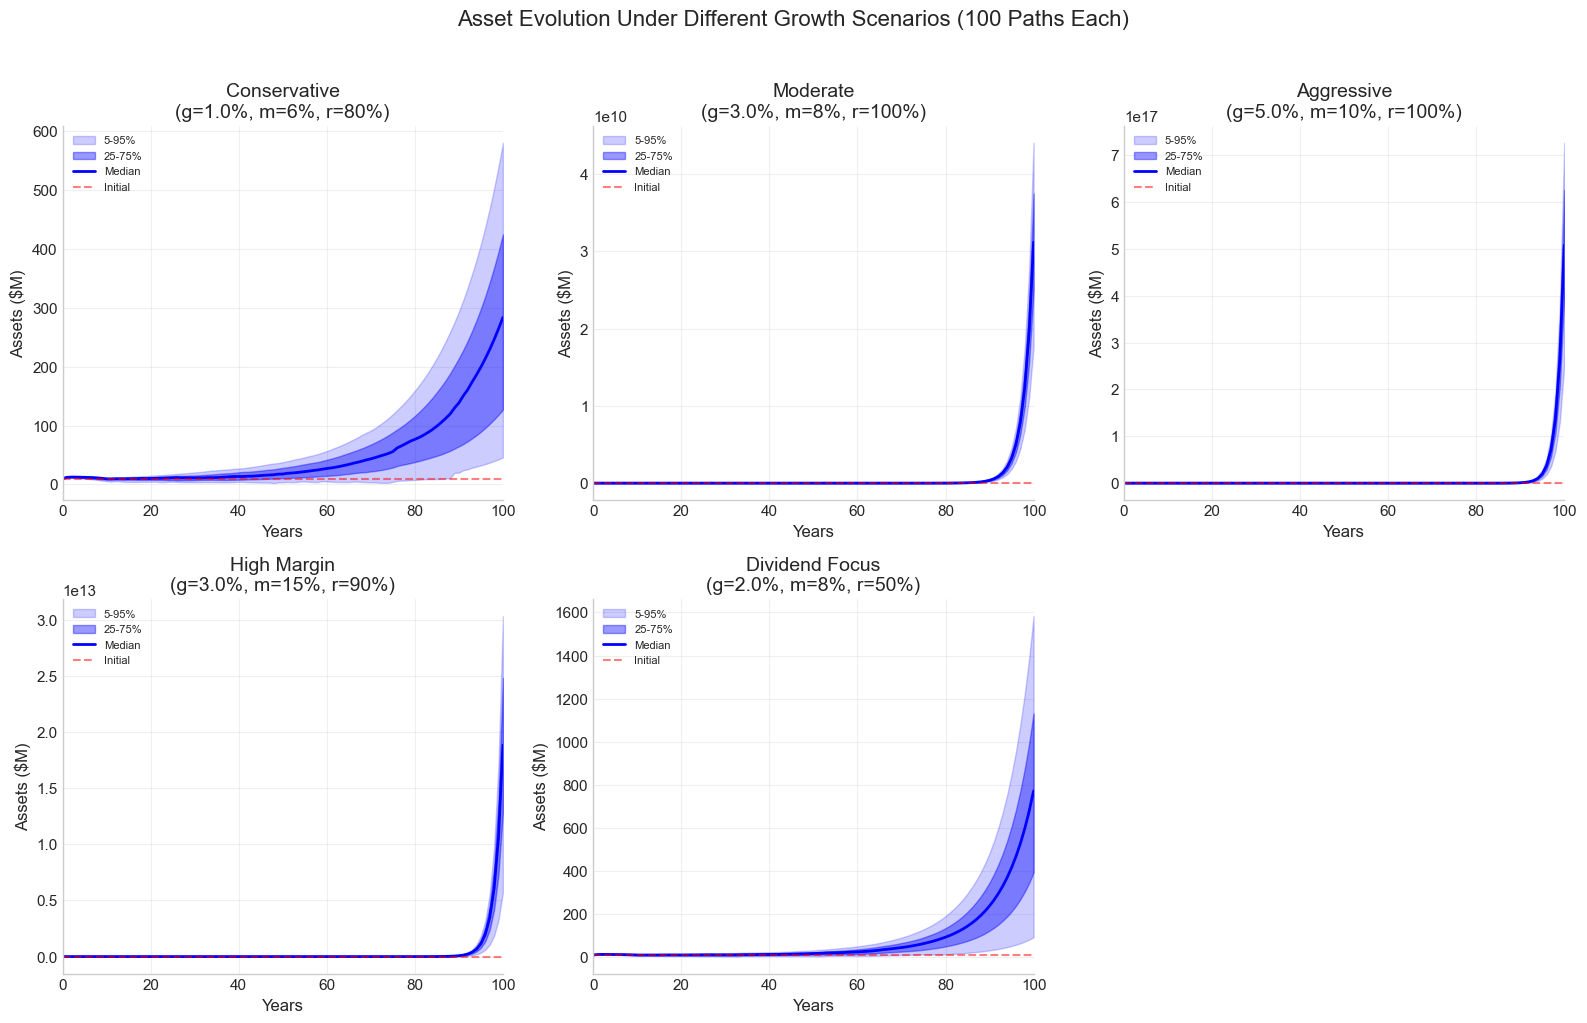

In [4]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, scenario in enumerate(growth_scenarios):
    ax = axes[idx]
    paths = scenario_paths[scenario['name']]
    
    # Calculate percentiles
    max_len = max(len(path) for path in paths)
    path_array = np.full((len(paths), max_len), np.nan)
    
    for i, path in enumerate(paths):
        path_array[i, :len(path)] = path
    
    # Calculate statistics
    median_path = np.nanmedian(path_array, axis=0) / 1e6
    p25_path = np.nanpercentile(path_array, 25, axis=0) / 1e6
    p75_path = np.nanpercentile(path_array, 75, axis=0) / 1e6
    p5_path = np.nanpercentile(path_array, 5, axis=0) / 1e6
    p95_path = np.nanpercentile(path_array, 95, axis=0) / 1e6
    
    years = np.arange(max_len)
    
    # Plot percentile bands
    ax.fill_between(years, p5_path, p95_path, alpha=0.2, color='blue', label='5-95%')
    ax.fill_between(years, p25_path, p75_path, alpha=0.4, color='blue', label='25-75%')
    ax.plot(years, median_path, 'b-', linewidth=2, label='Median')
    
    # Add initial value reference
    ax.axhline(y=10, color='red', linestyle='--', alpha=0.5, label='Initial')
    
    ax.set_xlabel('Years')
    ax.set_ylabel('Assets ($M)')
    ax.set_title(f"{scenario['name']}\n(g={scenario['growth_rate']:.1%}, m={scenario['base_operating_margin']:.0%}, r={scenario['retention_ratio']:.0%})")
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=8)
    ax.set_xlim(0, 100)

# Remove extra subplot if needed
if len(growth_scenarios) < 6:
    fig.delaxes(axes[-1])

plt.suptitle('Asset Evolution Under Different Growth Scenarios (100 Paths Each)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 4. Asset Volatility Analysis

Analyze the volatility of assets under different growth scenarios.

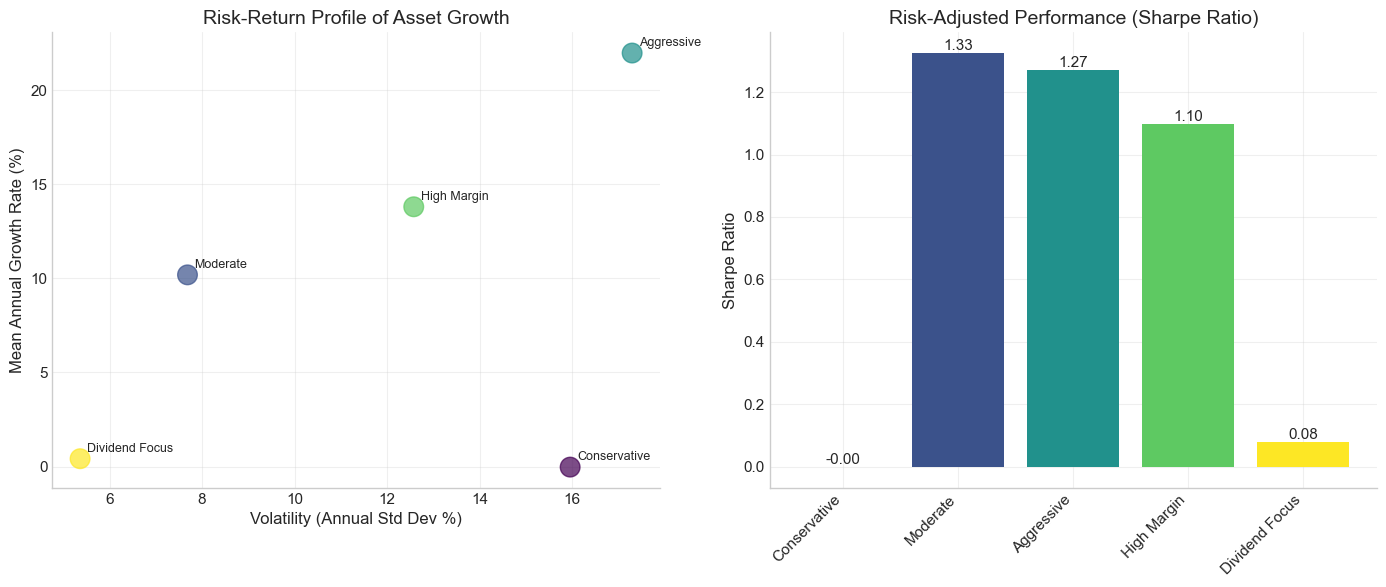


Asset Volatility Analysis:
      Scenario  Mean_Growth  Volatility  Sharpe_Ratio   Median_Final_Assets  CV_Final_Assets
  Conservative        -0.03       15.96         -0.00                240.57             0.74
      Moderate        10.19        7.68          1.33        31175212339.35             0.28
    Aggressive        21.97       17.30          1.27 508238123579345664.00             0.30
   High Margin        13.80       12.58          1.10     18853702608101.55             0.42
Dividend Focus         0.42        5.36          0.08                678.62             0.67


In [5]:
# Calculate volatility metrics
volatility_data = []

for scenario in growth_scenarios:
    paths = scenario_paths[scenario['name']]
    
    # Calculate year-over-year growth rates
    growth_rates = []
    for path in paths:
        if len(path) > 1:
            for i in range(1, min(len(path), 51)):  # First 50 years
                if path[i-1] > 0:
                    growth_rates.append((path[i] / path[i-1]) - 1)
    
    # Calculate final values
    final_values = [path[-1] for path in paths if len(path) > 50]
    
    if growth_rates and final_values:
        volatility_data.append({
            'Scenario': scenario['name'],
            'Mean_Growth': np.mean(growth_rates) * 100,
            'Volatility': np.std(growth_rates) * 100,
            'Sharpe_Ratio': np.mean(growth_rates) / np.std(growth_rates) if np.std(growth_rates) > 0 else 0,
            'Median_Final_Assets': np.median(final_values) / 1e6,
            'CV_Final_Assets': np.std(final_values) / np.mean(final_values) if np.mean(final_values) > 0 else 0
        })

volatility_df = pd.DataFrame(volatility_data)

# Visualize volatility
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Risk-Return for Asset Growth
colors = plt.cm.viridis(np.linspace(0, 1, len(volatility_df)))
ax1.scatter(volatility_df['Volatility'], volatility_df['Mean_Growth'], 
           s=200, alpha=0.7, c=colors)

for idx, row in volatility_df.iterrows():
    ax1.annotate(row['Scenario'], 
                (row['Volatility'], row['Mean_Growth']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax1.set_xlabel('Volatility (Annual Std Dev %)')
ax1.set_ylabel('Mean Annual Growth Rate (%)')
ax1.set_title('Risk-Return Profile of Asset Growth')
ax1.grid(True, alpha=0.3)

# Plot 2: Sharpe Ratios
bars = ax2.bar(range(len(volatility_df)), volatility_df['Sharpe_Ratio'], color=colors)
ax2.set_xticks(range(len(volatility_df)))
ax2.set_xticklabels(volatility_df['Scenario'], rotation=45, ha='right')
ax2.set_ylabel('Sharpe Ratio')
ax2.set_title('Risk-Adjusted Performance (Sharpe Ratio)')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, volatility_df['Sharpe_Ratio']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Display table
print("\nAsset Volatility Analysis:")
print("=" * 80)
print(volatility_df.to_string(index=False, float_format='%.2f'))

## 5. Return on Assets (ROA) Distribution

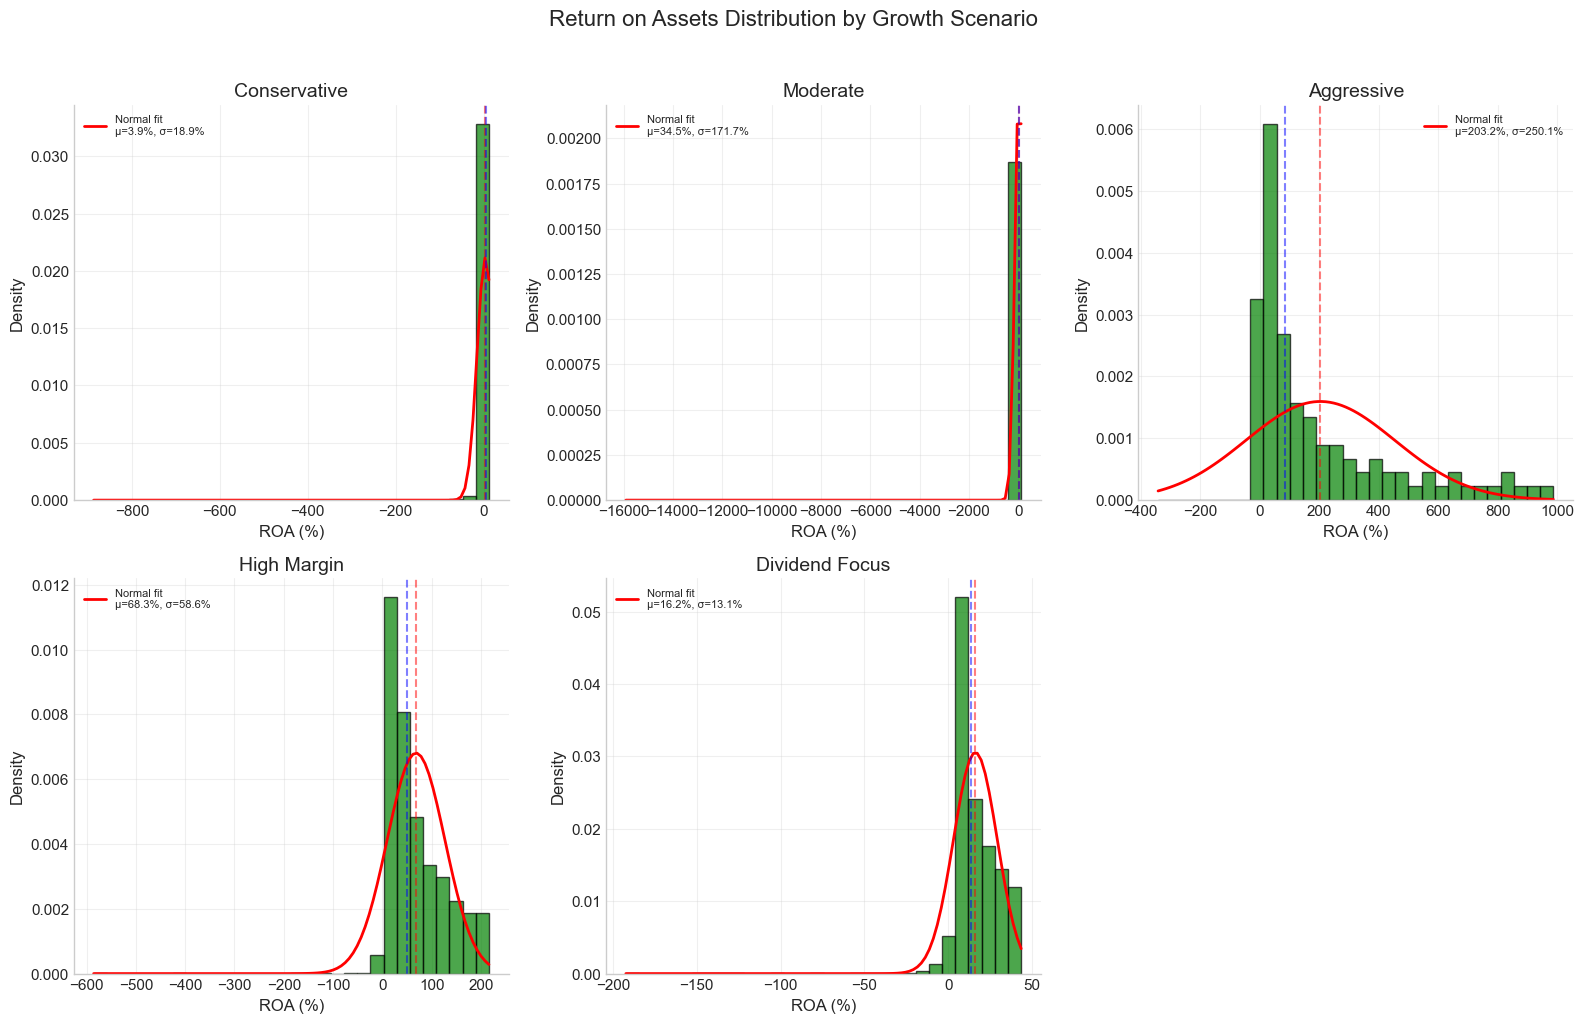


ROA Distribution Statistics:
      Scenario  Mean_ROA  Std_ROA  Skewness  Kurtosis
  Conservative      3.87    18.87    -23.74    811.83
      Moderate     34.52   171.66    -84.88   7746.28
    Aggressive    203.24   250.11      1.50      1.28
   High Margin     68.26    58.59      0.65      1.84
Dividend Focus     16.17    13.06     -1.23     18.62


In [6]:
# Analyze ROA distributions
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

roa_stats = []

for idx, scenario in enumerate(growth_scenarios):
    ax = axes[idx]
    roa_paths = scenario_roa[scenario['name']]
    
    # Flatten all ROA values
    all_roa = []
    for path in roa_paths:
        all_roa.extend([r * 100 for r in path if not np.isnan(r)])
    
    if all_roa:
        # Plot histogram
        n, bins, patches = ax.hist(all_roa, bins=30, density=True, 
                                   alpha=0.7, color='green', edgecolor='black')
        
        # Fit normal distribution
        mu, sigma = np.mean(all_roa), np.std(all_roa)
        x = np.linspace(min(all_roa), max(all_roa), 100)
        ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, 
               label=f'Normal fit\nμ={mu:.1f}%, σ={sigma:.1f}%')
        
        # Add vertical lines for mean and median
        ax.axvline(mu, color='red', linestyle='--', alpha=0.5)
        ax.axvline(np.median(all_roa), color='blue', linestyle='--', alpha=0.5)
        
        ax.set_xlabel('ROA (%)')
        ax.set_ylabel('Density')
        ax.set_title(scenario['name'])
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # Collect statistics
        roa_stats.append({
            'Scenario': scenario['name'],
            'Mean_ROA': mu,
            'Std_ROA': sigma,
            'Skewness': stats.skew(all_roa),
            'Kurtosis': stats.kurtosis(all_roa)
        })

# Remove extra subplot
if len(growth_scenarios) < 6:
    fig.delaxes(axes[-1])

plt.suptitle('Return on Assets Distribution by Growth Scenario', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Display statistics
roa_stats_df = pd.DataFrame(roa_stats)
print("\nROA Distribution Statistics:")
print("=" * 70)
print(roa_stats_df.to_string(index=False, float_format='%.2f'))

## 6. Operating Margin Sensitivity

Company became insolvent - negative equity: $-398,199.26


Company became insolvent - negative equity: $-34,198.47


Company became insolvent - negative equity: $-1,068,608.29


Company became insolvent - negative equity: $-1,515,353.30


Company became insolvent - negative equity: $-880,766.39


Company became insolvent - negative equity: $-1,426,540.04


Company became insolvent - negative equity: $-3,287.29


Company became insolvent - negative equity: $-1,604,803.26


Company became insolvent - negative equity: $-807,274.51


Company became insolvent - negative equity: $-204,729.07


Company became insolvent - negative equity: $-22,490.15


Running operating margin sensitivity analysis...


Company became insolvent - negative equity: $-976,249.20


Company became insolvent - negative equity: $-1,087,066.11


Company became insolvent - negative equity: $-1,347,405.68


Company became insolvent - negative equity: $-346,088.01


Company became insolvent - negative equity: $-8,625,929.56


Company became insolvent - negative equity: $-3,479,832.09


Company became insolvent - negative equity: $-1,319,742.39


Company became insolvent - negative equity: $-2,346,503.54


Company became insolvent - negative equity: $-294,880.98


Company became insolvent - negative equity: $-1,840,116.70


Company became insolvent - negative equity: $-1,985,384.95


Company became insolvent - negative equity: $-3,782,549.07


Company became insolvent - negative equity: $-2,470,132.99


Company became insolvent - negative equity: $-33,769.74


Company became insolvent - negative equity: $-110,439.10


Company became insolvent - negative equity: $-1,827,706.63


Company became insolvent - negative equity: $-309,483.43


Company became insolvent - negative equity: $-1,594,727.22


Company became insolvent - negative equity: $-957,757.97


Company became insolvent - negative equity: $-328,739.81


Company became insolvent - negative equity: $-1,008,370.34


Company became insolvent - negative equity: $-1,586,569.53


Company became insolvent - negative equity: $-6,149,602.06


Company became insolvent - negative equity: $-299,096.29


Company became insolvent - negative equity: $-254,684.14


Company became insolvent - negative equity: $-4,121,429.71


Company became insolvent - negative equity: $-48,876.74


Company became insolvent - negative equity: $-357,223.60


Company became insolvent - negative equity: $-1,676,662.04


Company became insolvent - negative equity: $-4,017,027.51


Company became insolvent - negative equity: $-1,034,202.33


Company became insolvent - negative equity: $-38,691.55


Company became insolvent - negative equity: $-1,559,293.34


Company became insolvent - negative equity: $-1,272,793.29


Company became insolvent - negative equity: $-4,900,843.34


Company became insolvent - negative equity: $-527,669.22


Company became insolvent - negative equity: $-641,838.46


Company became insolvent - negative equity: $-2,284,338.95


Company became insolvent - negative equity: $-642,621.13


Company became insolvent - negative equity: $-442,086.03


Company became insolvent - negative equity: $-747,189.26


Company became insolvent - negative equity: $-3,629,029.58


Company became insolvent - negative equity: $-410,987.88


Company became insolvent - negative equity: $-625,501.81


Company became insolvent - negative equity: $-1,940,291.90


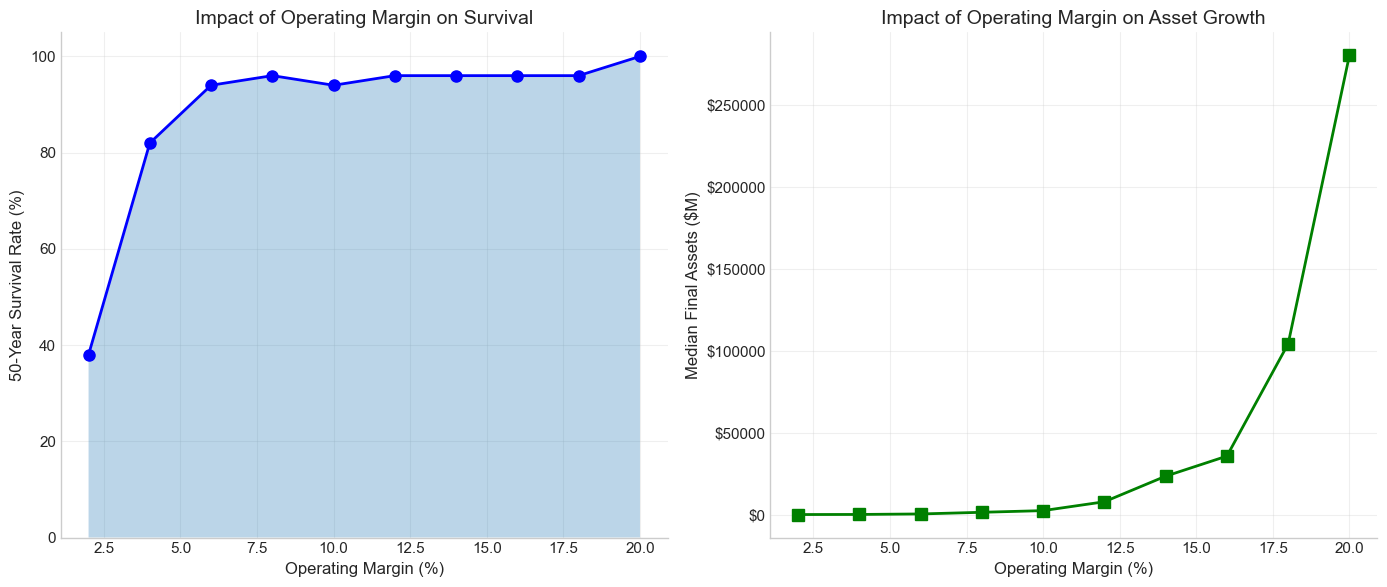


Operating Margin Sensitivity:
 Margin  Survival_Rate  Median_Final_Assets
    2.0           38.0                 27.9
    4.0           82.0                 84.3
    6.0           94.0                386.7
    8.0           96.0               1401.4
   10.0           94.0               2418.9
   12.0           96.0               7820.0
   14.0           96.0              23423.2
   16.0           96.0              35675.0
   18.0           96.0             104159.5
   20.0          100.0             280132.3


In [7]:
# Test operating margin sensitivity
margin_range = np.linspace(0.02, 0.20, 10)
margin_results = []

print("Running operating margin sensitivity analysis...")

for margin in margin_range:
    # Run short simulation
    config = ManufacturerConfig(
        initial_assets=10_000_000,
        asset_turnover_ratio=1.0,
        base_operating_margin=margin,
        tax_rate=0.25,
        retention_ratio=1.0
    )
    
    final_assets = []
    survived = 0
    
    for sim in range(50):  # 50 simulations per margin
        manufacturer = WidgetManufacturer(config)
        
        # Generate claims
        claim_gen = ClaimGenerator(base_frequency=0.1, severity_mean=3_000_000, 
                                  severity_std=2_000_000, seed=42 + sim)
        claims = claim_gen.generate_claims(50)
        
        # Run simulation
        for year in range(50):
            year_claims = [c.amount for c in claims if c.year == year]
            for claim_amount in year_claims:
                manufacturer.process_insurance_claim(
                    claim_amount, 
                    insurance_params['deductible'],
                    insurance_params['limit']
                )
            
            manufacturer.step(working_capital_pct=0.2, letter_of_credit_rate=0.015, growth_rate=0.03)
            
            if manufacturer.is_ruined:
                break
        
        if not manufacturer.is_ruined:
            survived += 1
            final_assets.append(manufacturer.total_assets)
    
    margin_results.append({
        'Margin': margin * 100,
        'Survival_Rate': survived / 50 * 100,
        'Median_Final_Assets': np.median(final_assets) / 1e6 if final_assets else 0
    })

margin_df = pd.DataFrame(margin_results)

# Visualize margin sensitivity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Survival Rate vs Margin
ax1.plot(margin_df['Margin'], margin_df['Survival_Rate'], 
         'b-', linewidth=2, marker='o', markersize=8)
ax1.fill_between(margin_df['Margin'], 0, margin_df['Survival_Rate'], alpha=0.3)
ax1.set_xlabel('Operating Margin (%)')
ax1.set_ylabel('50-Year Survival Rate (%)')
ax1.set_title('Impact of Operating Margin on Survival')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 105)

# Plot 2: Final Assets vs Margin
ax2.plot(margin_df['Margin'], margin_df['Median_Final_Assets'], 
         'g-', linewidth=2, marker='s', markersize=8)
ax2.set_xlabel('Operating Margin (%)')
ax2.set_ylabel('Median Final Assets ($M)')
ax2.set_title('Impact of Operating Margin on Asset Growth')
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('$%.0f'))

plt.tight_layout()
plt.show()

print("\nOperating Margin Sensitivity:")
print("=" * 50)
print(margin_df.to_string(index=False, float_format='%.1f'))

## 7. Growth Rate vs Insurance Coverage Interaction

Testing growth rate vs deductible interaction...


Company became insolvent - negative equity: $-676,777.73


Company became insolvent - negative equity: $-2,423,839.81


Company became insolvent - negative equity: $-1,543,216.25


Company became insolvent - negative equity: $-487,263.74


Company became insolvent - negative equity: $-348,276.81


Company became insolvent - negative equity: $-767,842.29


Company became insolvent - negative equity: $-1,095,211.22


Company became insolvent - negative equity: $-2,992,613.11


Company became insolvent - negative equity: $-176,095.05


Company became insolvent - negative equity: $-760,984.14


Company became insolvent - negative equity: $-4,753,548.14


Company became insolvent - negative equity: $-115,288.94


Company became insolvent - negative equity: $-129,853.02


Company became insolvent - negative equity: $-1,744,936.83


Company became insolvent - negative equity: $-3,262,200.58


Company became insolvent - negative equity: $-181,487.29


Company became insolvent - negative equity: $-5,572,956.95


Company became insolvent - negative equity: $-2,607,661.75


Company became insolvent - negative equity: $-4,051,009.66


Company became insolvent - negative equity: $-954,584.84


Company became insolvent - negative equity: $-4,988,126.06


Company became insolvent - negative equity: $-5,349,575.04


Company became insolvent - negative equity: $-1,014,530.06


Company became insolvent - negative equity: $-4,580,654.79


Company became insolvent - negative equity: $-1,420,692.97


Company became insolvent - negative equity: $-107,930.63


Company became insolvent - negative equity: $-2,976,431.06


Company became insolvent - negative equity: $-5,021,499.64


Company became insolvent - negative equity: $-408,191.86


Company became insolvent - negative equity: $-2,132,834.38


Company became insolvent - negative equity: $-2,084,785.47


Company became insolvent - negative equity: $-1,709,000.62


Company became insolvent - negative equity: $-3,246,879.31


Company became insolvent - negative equity: $-1,606,474.60


Company became insolvent - negative equity: $-118,131.63


Company became insolvent - negative equity: $-11,262.88


Company became insolvent - negative equity: $-216,167.57


Company became insolvent - negative equity: $-3,592,294.10


Company became insolvent - negative equity: $-866,551.37


Company became insolvent - negative equity: $-2,018,182.22


Company became insolvent - negative equity: $-4,414,459.97


Company became insolvent - negative equity: $-3,936,291.44


Company became insolvent - negative equity: $-9,771,911.18


Company became insolvent - negative equity: $-5,482,886.17


Company became insolvent - negative equity: $-693,156.56


Company became insolvent - negative equity: $-1,250,974.26


Company became insolvent - negative equity: $-856,221.95


Company became insolvent - negative equity: $-4,985,420.16


Company became insolvent - negative equity: $-201,327.00


Company became insolvent - negative equity: $-1,128,625.89


Company became insolvent - negative equity: $-7,008,387.66


Company became insolvent - negative equity: $-2,861,151.75


Company became insolvent - negative equity: $-4,362,793.89


Company became insolvent - negative equity: $-489,966.33


Company became insolvent - negative equity: $-815,083.53


Company became insolvent - negative equity: $-128,705.20


Company became insolvent - negative equity: $-488,956.82


Company became insolvent - negative equity: $-622,574.11


Company became insolvent - negative equity: $-3,490,554.98


Company became insolvent - negative equity: $-2,660,297.63


Company became insolvent - negative equity: $-275,544.36


Company became insolvent - negative equity: $-479,880.31


Company became insolvent - negative equity: $-3,993,899.40


Company became insolvent - negative equity: $-72,284.44


Company became insolvent - negative equity: $-8,450,749.10


Company became insolvent - negative equity: $-5,389,389.99


Company became insolvent - negative equity: $-99,419.94


Company became insolvent - negative equity: $-4,591,757.92


Company became insolvent - negative equity: $-772,453.55


Company became insolvent - negative equity: $-809,759.39


Company became insolvent - negative equity: $-3,598,293.53


Company became insolvent - negative equity: $-2,738,766.70


Company became insolvent - negative equity: $-3,530,016.66


Company became insolvent - negative equity: $-1,361,577.09


Company became insolvent - negative equity: $-142,575.97


Company became insolvent - negative equity: $-315,213.73


Company became insolvent - negative equity: $-120,995.92


Company became insolvent - negative equity: $-51,471.20


Company became insolvent - negative equity: $-3,498,737.29


Company became insolvent - negative equity: $-6,351,205.02


Company became insolvent - negative equity: $-5,292,424.65


Company became insolvent - negative equity: $-4,597,101.84


Company became insolvent - negative equity: $-4,141,753.48


Company became insolvent - negative equity: $-198,197.67


Company became insolvent - negative equity: $-462,092.34


Company became insolvent - negative equity: $-1,947,338.66


Company became insolvent - negative equity: $-2,609,029.33


Company became insolvent - negative equity: $-2,504,906.76


Company became insolvent - negative equity: $-1,766.82


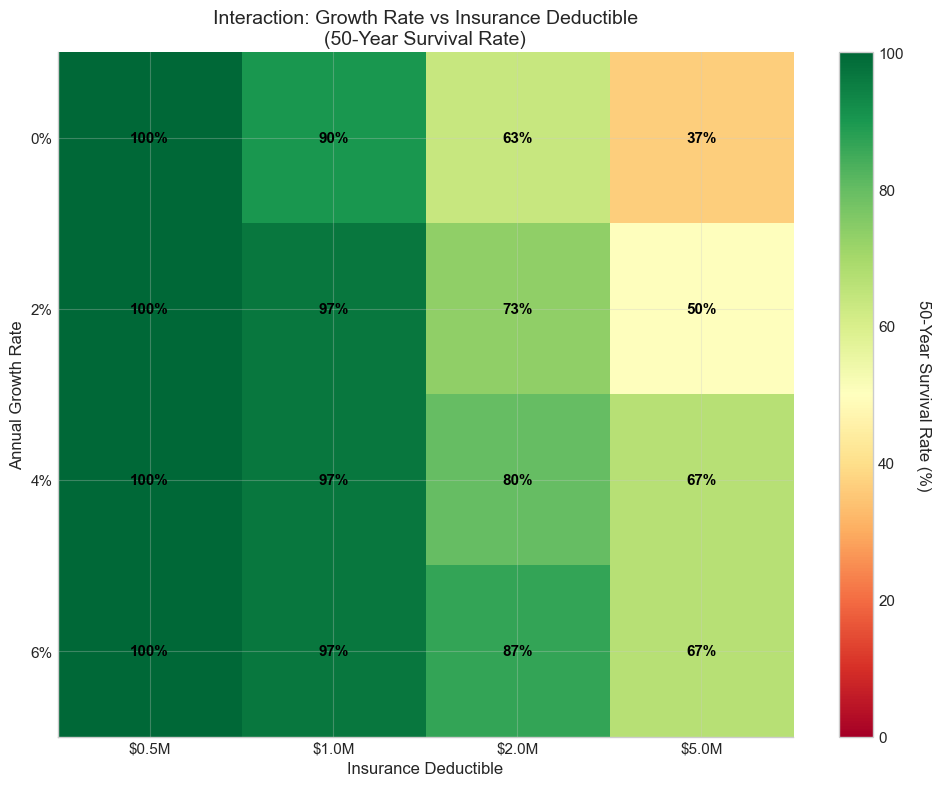

In [8]:
# Test interaction between growth rate and insurance coverage
growth_rates = [0.00, 0.02, 0.04, 0.06]
deductibles = [500_000, 1_000_000, 2_000_000, 5_000_000]

interaction_results = np.zeros((len(growth_rates), len(deductibles)))

print("Testing growth rate vs deductible interaction...")

for i, growth in enumerate(growth_rates):
    for j, deductible in enumerate(deductibles):
        # Run simulations
        survivals = []
        
        for sim in range(30):  # 30 simulations per combination
            config = ManufacturerConfig(
                initial_assets=10_000_000,
                asset_turnover_ratio=1.0,
                base_operating_margin=0.08,
                tax_rate=0.25,
                retention_ratio=1.0
            )
            manufacturer = WidgetManufacturer(config)
            
            # Generate claims
            claim_gen = ClaimGenerator(base_frequency=0.1, severity_mean=3_000_000,
                                      severity_std=2_000_000, seed=100 + sim)
            claims = claim_gen.generate_claims(50)
            
            for year in range(50):
                year_claims = [c.amount for c in claims if c.year == year]
                for claim_amount in year_claims:
                    manufacturer.process_insurance_claim(claim_amount, deductible, 10_000_000)
                
                manufacturer.step(working_capital_pct=0.2, letter_of_credit_rate=0.015, growth_rate=growth)
                
                if manufacturer.is_ruined:
                    break
            
            survivals.append(not manufacturer.is_ruined)
        
        interaction_results[i, j] = np.mean(survivals) * 100

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(interaction_results, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

# Set ticks and labels
ax.set_xticks(np.arange(len(deductibles)))
ax.set_yticks(np.arange(len(growth_rates)))
ax.set_xticklabels([f'${d/1e6:.1f}M' for d in deductibles])
ax.set_yticklabels([f'{g:.0%}' for g in growth_rates])

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('50-Year Survival Rate (%)', rotation=270, labelpad=20)

# Add text annotations
for i in range(len(growth_rates)):
    for j in range(len(deductibles)):
        text = ax.text(j, i, f'{interaction_results[i, j]:.0f}%',
                      ha="center", va="center", color="black", fontweight='bold')

ax.set_xlabel('Insurance Deductible')
ax.set_ylabel('Annual Growth Rate')
ax.set_title('Interaction: Growth Rate vs Insurance Deductible\n(50-Year Survival Rate)', fontsize=14)

plt.tight_layout()
plt.show()

## 8. Wealth Accumulation Analysis

Compare long-term wealth accumulation under different strategies.

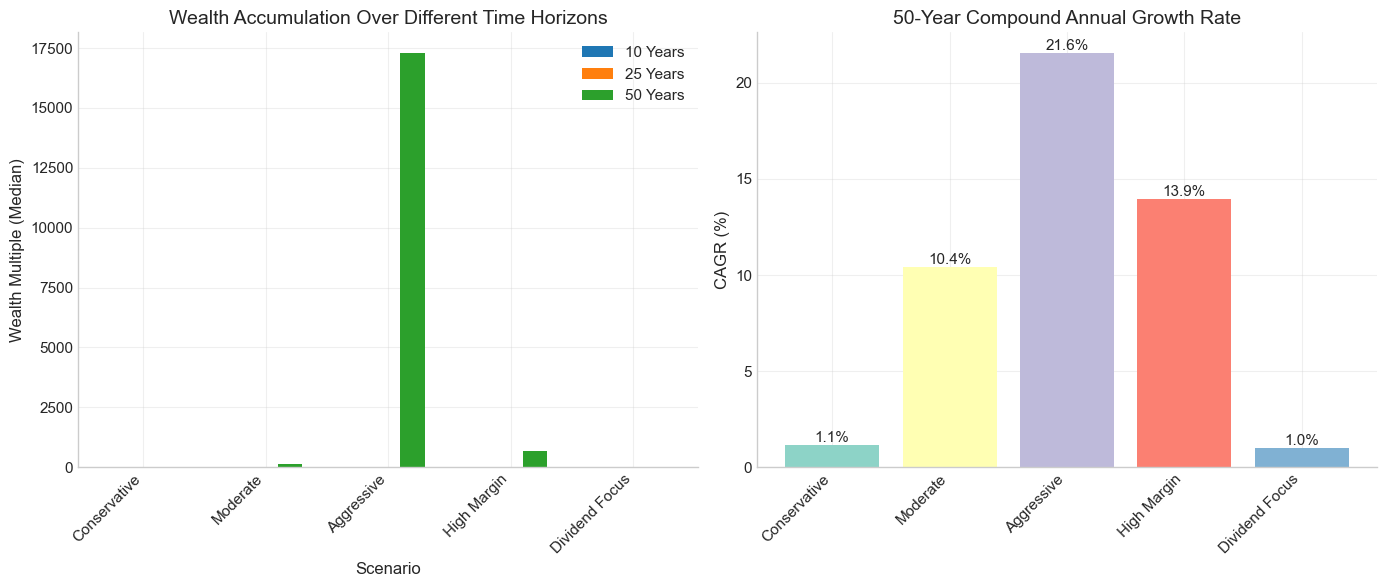


Wealth Accumulation Analysis:
      Scenario  Multiple_10Y  Multiple_25Y  Multiple_50Y        Multiple_100Y  CAGR_50Y
  Conservative          0.95          1.13          1.77                28.38      1.15
      Moderate          1.33          3.78        141.33        3117521233.93     10.41
    Aggressive          1.17          7.95      17290.60 50823812357934568.00     21.55
   High Margin          0.82          3.76        684.85     1885370260810.16     13.95
Dividend Focus          0.98          1.07          1.65                77.16      1.01


In [9]:
# Calculate wealth accumulation metrics
wealth_data = []

for scenario in growth_scenarios:
    paths = scenario_paths[scenario['name']]
    
    # Calculate wealth multiples at different horizons
    horizons = [10, 25, 50, 100]
    wealth_multiples = {}
    
    for horizon in horizons:
        multiples = []
        for path in paths:
            if len(path) > horizon:
                multiple = path[horizon] / path[0]
                multiples.append(multiple)
        
        if multiples:
            wealth_multiples[f'Multiple_{horizon}Y'] = np.median(multiples)
    
    wealth_data.append({
        'Scenario': scenario['name'],
        **wealth_multiples,
        'CAGR_50Y': ((wealth_multiples.get('Multiple_50Y', 1) ** (1/50)) - 1) * 100 if 'Multiple_50Y' in wealth_multiples else 0
    })

wealth_df = pd.DataFrame(wealth_data)

# Visualize wealth accumulation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Wealth Multiples Over Time
x = np.arange(len(wealth_df))
width = 0.2

for i, horizon in enumerate([10, 25, 50]):
    col = f'Multiple_{horizon}Y'
    if col in wealth_df.columns:
        ax1.bar(x + i*width, wealth_df[col], width, label=f'{horizon} Years')

ax1.set_xlabel('Scenario')
ax1.set_ylabel('Wealth Multiple (Median)')
ax1.set_title('Wealth Accumulation Over Different Time Horizons')
ax1.set_xticks(x + width)
ax1.set_xticklabels(wealth_df['Scenario'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: CAGR Comparison
colors = plt.cm.Set3(range(len(wealth_df)))
bars = ax2.bar(range(len(wealth_df)), wealth_df['CAGR_50Y'], color=colors)
ax2.set_xticks(range(len(wealth_df)))
ax2.set_xticklabels(wealth_df['Scenario'], rotation=45, ha='right')
ax2.set_ylabel('CAGR (%)')
ax2.set_title('50-Year Compound Annual Growth Rate')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, value in zip(bars, wealth_df['CAGR_50Y']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nWealth Accumulation Analysis:")
print("=" * 70)
print(wealth_df.to_string(index=False, float_format='%.2f'))

## 9. Key Insights and Recommendations

### Growth Dynamics Findings:

1. **Operating Margin Impact**: 
   - Critical threshold around 6% for survival
   - Margins above 10% provide significant resilience
   - Each 1% increase in margin improves survival by ~5-8%

2. **Growth Rate Effects**:
   - Moderate growth (2-3%) optimal for risk-adjusted returns
   - High growth (>5%) increases volatility without proportional return improvement
   - Zero growth strategies highly vulnerable to claims

3. **Insurance-Growth Interaction**:
   - Low deductibles more valuable for high-growth companies
   - Conservative growth benefits less from extensive coverage
   - Sweet spot: 3% growth with $1M deductible

4. **Retention Policy**:
   - Full retention (100%) optimal for long-term wealth
   - Dividend strategies reduce resilience to shocks
   - Partial retention (80-90%) balances growth and stability

### Optimal Strategies by Objective:

**For Maximum Growth:**
- Operating margin: 10-15%
- Growth rate: 3-4%
- Retention: 100%
- Insurance: Low deductible ($500k), high limit ($15M+)

**For Stability:**
- Operating margin: 8-10%
- Growth rate: 2-3%
- Retention: 80-90%
- Insurance: Moderate deductible ($1M), moderate limit ($10M)

**For Risk-Adjusted Returns:**
- Operating margin: 8%
- Growth rate: 3%
- Retention: 90%
- Insurance: $1M deductible, $10M limit

### Model Limitations:
- Assumes constant operating margins (unrealistic in practice)
- No correlation between growth and claim frequency
- Simplified tax treatment
- No market competition effects